# COSMO Project
By Mathilde Raynal, Etienne Bonvin and Xavier Pantet

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import random
from regressions import *
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [3]:
DATA_FOLDER = "data/"
X = np.load(DATA_FOLDER + "feature_mat_radial_compression.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")

In [4]:
print("X: " + str(X.shape))
print("y: " + str(y.shape))

X: (30049, 15961)
y: (30049,)


In [5]:
x_df = pd.DataFrame(X)

In [6]:
x_df = x_df.drop_duplicates()
print("X: " + str(x_df.shape))

X: (30049, 15961)


In [7]:
def split(x_df, y, perc):
    train_set_size = int(x_df.shape[0] * 0.75)
    x_tr = x_df.head(train_set_size)
    x_te = x_df.tail(int(x_df.shape[0] - train_set_size))
    y_tr = y[: train_set_size]
    y_te = y[train_set_size :]
    return x_tr, y_tr, x_te, y_te

In [ ]:
def test_quality(x_df, y):
    test_perc = 0.75
    x_train, y_train, x_test, y_test = split(x_df, y, test_perc)
    best = 100
    for lambda_ in [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9]:
        err = rmse(y_test, x_test, ridge_regression(y_train, x_train, lambda_))
        best = err if err < best else best
    return best

In [9]:
test_quality(x_df, y)

0.7388125569787584

### Data augmentation

In [10]:
#To remove bias
def add_cte_col(df):
    df[df.shape[1]] = pd.Series(np.ones(df.shape[0]), index=df.index)

In [11]:
#to have more samples
def add_jitter(df, y, perc_sample, perc_col):
    means = [df[j].mean() for j in df]
    df_tmp = df.copy()
    y_tmp = y.copy()
    ids = random.sample(range(df_tmp.shape[0]), int(df_tmp.shape[0]*perc_sample))
    for id_ in ids:
        new_sample = df_tmp.iloc[[id_]].copy()
        col = random.sample(range(df_tmp.shape[1]), int(df_tmp.shape[1]*perc_col))
        for j in col:
            new_sample[j] = new_sample[j] + 0.01*means[j]
        df_tmp = df_tmp.append(new_sample, ignore_index=True)
        y_tmp = np.append(y_tmp, y_tmp[id_])
    return df_tmp, y_tmp        

In [12]:
x_df_aug, y_aug = add_jitter(x_df, y, 0.01, 0.01)

In [13]:
print(x_df_aug.shape)
print(y_aug.shape)
test_quality(x_df_aug, y_aug)

(30349, 15961)
(30349,)


0.720066359539529

### Normalization:

In [14]:
x_df=(x_df-x_df.mean())/x_df.std()
x_df = x_df.drop(15960, axis=1)
x_df

,0,1,2,3,4,5,6,7,8,9,...,15950,15951,15952,15953,15954,15955,15956,15957,15958,15959
0,-1.117537,0.130346,0.013696,-0.103711,0.037901,0.269922,0.399752,0.415404,0.358259,0.303114,...,-0.393410,-0.301521,-0.367537,-0.394536,-0.370814,-0.407677,-0.416760,-0.401391,-0.409848,-0.426182
1,-1.141154,0.360481,0.266127,0.079885,0.149372,0.394671,0.586697,0.697098,0.761406,0.658471,...,-0.439485,-0.473423,-0.539600,-0.589093,-0.570107,-0.601153,-0.609641,-0.615344,-0.617178,-0.622111
2,-1.177216,-0.267615,-0.349863,-0.416966,-0.393240,-0.265429,-0.145420,-0.109582,-0.151950,-0.193078,...,-0.430591,-0.422903,-0.480570,-0.536433,-0.519772,-0.540244,-0.550040,-0.558432,-0.558878,-0.562048
3,-1.125873,0.708498,0.511915,0.345341,0.678018,0.960304,0.994918,0.879390,0.731289,0.780614,...,-0.458453,-0.547680,-0.616144,-0.673036,-0.654511,-0.685598,-0.695242,-0.707149,-0.706268,-0.709202
4,-1.301681,0.035031,-0.075285,-0.190359,-0.102609,0.108780,0.216456,0.411433,0.163525,0.113291,...,-0.494304,-0.691341,-0.765498,-0.832934,-0.815301,-0.849757,-0.864321,-0.889805,-0.880755,-0.883626
5,-1.289225,0.618264,0.440396,0.333169,0.531440,0.795734,0.815010,0.934647,0.583534,0.673116,...,-0.493536,-0.691717,-0.767147,-0.832168,-0.814264,-0.850489,-0.864632,-0.889108,-0.880674,-0.884081
6,-1.280896,-0.263859,-0.355730,-0.418794,-0.397849,-0.229321,-0.186046,-0.037326,-0.213264,-0.233464,...,-0.490703,-0.694423,-0.769091,-0.828314,-0.812143,-0.851598,-0.864812,-0.884870,-0.880759,-0.885678
7,-1.244046,0.480159,0.363812,0.202020,0.349861,0.564196,0.670118,0.849204,0.574173,0.503616,...,-0.484862,-0.684433,-0.766651,-0.814271,-0.794596,-0.843836,-0.857055,-0.869302,-0.864939,-0.877402
8,-1.121709,0.117122,0.008087,-0.111065,0.043313,0.242077,0.372759,0.408476,0.373977,0.232905,...,-0.388380,-0.487897,-0.678482,-0.671614,-0.536393,-0.580206,-0.699196,-0.727652,-0.622976,-0.591967
9,-1.120282,0.673164,0.520629,0.353339,0.604866,0.836481,0.911321,0.919284,0.833911,0.680132,...,-0.430117,-0.472262,-0.542216,-0.584586,-0.566216,-0.587505,-0.606463,-0.627249,-0.609860,-0.606361


In [ ]:
test_x_df = x_df.copy()
add_cte_col(test_x_df)
test_quality(x_df, y)

### Correlation:

In [16]:
to_rm = []
for i in [i for i in x_df if i < 50]:
    for j in [j for j in x_df if j > i]:
        if x_df[i].corr(x_df[j]) > 0.95:
            to_rm.append(j)
x_df_uncorr = x_df.drop(to_rm, axis=1)

In [17]:
print(x_df_uncorr.shape)
add_cte_col(x_df_uncorr)
test_quality(x_df_uncorr, y)

(30049, 15915)


1.1669052810540885

### PCA

In [18]:
rmses = []
ys = range(500, 5501, 500)
for i in ys:
    pca = PCA(n_components=i, whiten=True)
    principalComponents = pca.fit_transform(x_df, x_df.shape)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = range(principalComponents.shape[1]))
    add_cte_col(principalDf)
    err = test_quality(principalDf, y)
    rmses.append(err)
    print(i, err)

500 1.2262302269697645
1000 1.0870860098196697
1500 1.0176960660160574
2000 0.9912237290843013
2500 0.9584484693741699
3000 0.9674442297370911
3500 1.0279234748222406
4000 0.9841759499638348
4500 0.9646751090235239
5000 0.9616945851717027
5500 0.9344057368907643


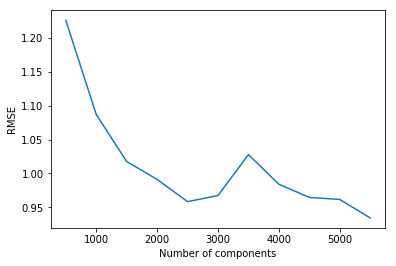

In [19]:
plt.xlabel("Number of components")
plt.ylabel("RMSE")
plt.plot(ys, rmses)
plt.show()

In [23]:
i_star = 3003
pca = PCA(n_components=i_star, whiten=True)
principalComponents = pca.fit_transform(x_df, x_df.shape)
principalDf_star = pd.DataFrame(data = principalComponents
             , columns = range(principalComponents.shape[1]))
add_cte_col(principalDf_star)
test_quality(principalDf_star, y)

1.0061253889894468

In [28]:
i_star = 3003
pca = PCA(n_components=i_star)
principalComponents_no_w = pca.fit_transform(x_df, x_df.shape)
principalDf_star_no_w = pd.DataFrame(data = principalComponents_no_w
             , columns = range(principalComponents_no_w.shape[1]))
add_cte_col(principalDf_star_no_w)
test_quality(principalDf_star_no_w, y)

0.7722171566232727

In [ ]:
principalDf_star.columns = range(principalDf_star.shape[1])
np.save("data/pca_x_w.npy", principalDf_star)

In [ ]:
principalDf_star_no_w.columns = range(principalDf_star_no_w.shape[1])
np.save("data/pca_x_3004_no_w.npy", principalDf_star_no_w)

In [ ]:
#ValueError: math domain error is known bug : https://github.com/scikit-learn/scikit-learn/issues/10217: Cannot use MLE

### Preparing the data for Deep Learning

In [33]:
DATA_FOLDER = "data/"
X = np.load(DATA_FOLDER + "feature_mat_radial_compression.npy")
y = np.load(DATA_FOLDER + "CSD500-r_train-H_total.npy")
x_df = pd.DataFrame(X)

In [35]:
#Apply PCA
i_star = 3004
pca = PCA(n_components=i_star)
principalComponents = pca.fit_transform(x_df, x_df.shape)
x_pca_df = pd.DataFrame(data = principalComponents
             , columns = range(principalComponents.shape[1]))
x_pca_df.columns = range(x_pca_df.shape[1])

In [36]:
#Split the data 75-25
x_train_df, y_train, x_test_df, y_test = split(x_pca_df, y, 0.75)

In [37]:
#Add jitter
train_df_with_jitter, y_with_jitter = add_jitter(x_train_df, y_train, 0.01, 0.01)

In [38]:
#Normalize
train_df_with_jitter=(train_df_with_jitter-train_df_with_jitter.mean())/train_df_with_jitter.std()
test_df =(x_test_df-x_test_df.mean())/x_test_df.std()
train_df_with_jitter

,0,1,2,3,4,5,6,7,8,9,...,2994,2995,2996,2997,2998,2999,3000,3001,3002,3003
0,-1.177929,-1.256078,0.978584,-0.150991,0.316359,0.857803,0.375858,-0.796871,-0.879487,-0.444742,...,1.127870,-0.607071,-1.381066,-0.681115,-0.826206,-0.435790,-0.562929,-0.155686,-0.978700,-0.225084
1,-1.158266,-1.254333,0.911904,-0.095431,0.369294,0.817685,0.480827,-0.530296,-0.773898,-0.844119,...,0.743213,-0.925905,-0.964841,0.255121,-0.979815,-0.076657,-1.042003,0.283721,-0.621243,0.040914
2,-1.148346,-1.261795,0.854778,-0.065668,0.436171,0.900933,0.416422,-0.762824,-0.919097,-0.677769,...,1.226945,-0.876233,-1.463661,-0.207924,-1.298354,-0.046785,-0.879353,-0.469879,-0.789102,0.014529
3,-1.167087,-1.258439,0.817838,-0.049902,0.428427,0.817211,0.316808,-0.796782,-0.785921,-0.578061,...,1.956172,-0.778254,-1.330515,-0.388971,-1.154841,0.020346,-1.902388,0.186673,-0.675118,0.237224
4,-0.927583,-1.316173,-0.756486,0.578926,0.083610,-0.148527,-0.153197,0.353300,-0.903503,-0.841073,...,0.236403,-0.758535,0.191329,-0.673496,0.467904,-0.328031,1.213860,-0.377380,-0.763496,-0.172560
5,-0.935406,-1.282938,-0.920266,0.559823,-0.175786,-0.289600,0.012018,0.216130,-1.240074,-0.871012,...,0.601229,-0.982725,0.354675,-0.006360,0.913250,0.008765,1.547107,1.244338,-0.040475,0.611205
6,-0.948032,-1.307091,-0.808370,0.517181,-0.137592,-0.155502,-0.255089,0.395754,-0.797889,-0.437879,...,0.439752,0.051087,0.385606,-0.452491,-0.386179,-0.439704,0.659965,-0.632714,-0.365590,0.378523
7,-0.919752,-1.288171,-0.763759,0.516733,-0.062375,-0.093878,-0.044522,0.361822,-0.958265,-0.989894,...,0.845558,-1.061718,0.459069,0.153348,0.292248,-0.463969,1.257628,0.163055,-0.214581,0.137282
8,-0.863690,-1.305859,0.073347,0.163435,-0.209398,0.234158,-1.564116,0.407282,0.549099,-0.016841,...,0.687452,-0.083579,-0.961009,-0.067788,1.126675,-1.124309,0.443973,1.351186,-0.600942,0.335088
9,-0.854928,-1.254573,0.021484,0.095174,-0.394126,0.237632,-1.945137,0.387565,0.445812,-0.010847,...,1.204093,-0.326004,-0.706961,-0.593185,1.225812,-0.345999,0.187933,0.301376,-0.175468,0.046110


In [40]:
np.save("data/DL/x_train.npy", train_df_with_jitter)
np.save("data/DL/x_test.npy", x_test_df)
np.save("data/DL/y_train.npy", y_with_jitter)
np.save("data/DL/y_test.npy", y_test)